# 0. Set Up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 텍스트 데이터에서 이모지 제거하기 위한 라이브러리
! pip install cleantext
# ! pip install clean-text[gpl]==0.4.0

# 1. HateXplain 데이터 전처리
- 혐오표현 데이터로 [HateXplain](https://github.com/hate-alert/HateXplain) 선정
  - Twitter와 Gab으로부터 텍스트 데이터를 수집하여 구축됨
  - 텍스트 내용에 따라 normal, offensive, hatespeech 세 가지 클래스로 라벨링 되어있음
- 실험에 앞서 데이터 전처리 진행
  - 어노테이터들의 의견을 취합해 가장 많이 뽑힌 클래스 하나만 해당 샘플의 라벨로 선정
  - 'inconclusive' 라벨을 가진 샘플 제거, ID source가 분명하지 않은 샘플들 제거
  - 토큰 리스트로 구성되어 있던 post_token 원본 데이터를 한 string으로 합침
  - 이모지 및 `<user>, <number>, <percent>` 태그 제거
- 불균형 데이터 확보
  - 클래스 분포 확인 결과 abusive comment (offensive, hate)의 비율이 전체의 59%를 차지함
  - 실험 가설과 real-life situation에 맞춰 불균형성을 부여함 (59% -> 42%)

In [ ]:
# HateXplain 데이터셋 다운로드
!wget -O dataset.json https://raw.githubusercontent.com/hate-alert/HateXplain/refs/heads/master/Data/dataset.json

--2024-11-08 04:35:05--  https://raw.githubusercontent.com/hate-alert/HateXplain/refs/heads/master/Data/dataset.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12256170 (12M) [text/plain]
Saving to: ‘dataset.json’

dataset.json        100%[===================>]  11.69M  --.-KB/s    in 0.04s   

2024-11-08 04:35:06 (322 MB/s) - ‘dataset.json’ saved [12256170/12256170]



In [ ]:
# JSON data로부터 데이터프레임 생성
df = pd.read_json('dataset.json').transpose()
df = df.drop(columns=['rationales'])
df.head()

,post_id,annotators,post_tokens
1179055004553900032_twitter,1179055004553900032_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...","[i, dont, think, im, getting, my, baby, them, ..."
1179063826874032128_twitter,1179063826874032128_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...","[we, cannot, continue, calling, ourselves, fem..."
1178793830532956161_twitter,1178793830532956161_twitter,"[{'label': 'normal', 'annotator_id': 4, 'targe...","[nawt, yall, niggers, ignoring, me]"
1179088797964763136_twitter,1179088797964763136_twitter,"[{'label': 'hatespeech', 'annotator_id': 1, 't...","[<user>, i, am, bit, confused, coz, chinese, p..."
1179085312976445440_twitter,1179085312976445440_twitter,"[{'label': 'hatespeech', 'annotator_id': 4, 't...","[this, bitch, in, whataburger, eating, a, burg..."


In [ ]:
# 어노테이터들의 선택에 따라 가장 많이 뽑힌 label만을 선정해 각 샘플의 최종 label 결정
def choose_label(anns):
    maj = len(anns) -1
    normal = 0
    hatespeech = 0
    offensive = 0
    for each in anns:
        if each['label'] == 'normal':
            normal += 1
        elif each['label'] == 'hatespeech':
            hatespeech +=1
        else:
            offensive +=1
    if normal >= maj:
        return 'normal'
    elif hatespeech >= maj:
        return 'hate'
    elif offensive >= maj:
        return 'offensive'
    else:
        return 'inconclusive'

df['label'] = df['annotators'].apply(choose_label)
df.head()

,post_id,annotators,post_tokens,label
1179055004553900032_twitter,1179055004553900032_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...","[i, dont, think, im, getting, my, baby, them, ...",normal
1179063826874032128_twitter,1179063826874032128_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...","[we, cannot, continue, calling, ourselves, fem...",normal
1178793830532956161_twitter,1178793830532956161_twitter,"[{'label': 'normal', 'annotator_id': 4, 'targe...","[nawt, yall, niggers, ignoring, me]",normal
1179088797964763136_twitter,1179088797964763136_twitter,"[{'label': 'hatespeech', 'annotator_id': 1, 't...","[<user>, i, am, bit, confused, coz, chinese, p...",hate
1179085312976445440_twitter,1179085312976445440_twitter,"[{'label': 'hatespeech', 'annotator_id': 4, 't...","[this, bitch, in, whataburger, eating, a, burg...",hate


In [ ]:
# 'inconclusive' 라벨을 가진 샘플은 제거
inconclusive = df.loc[df['label'] == 'inconclusive']
df.drop(inconclusive.index, inplace = True)

In [ ]:
# ID의 source가 분명하지 않은 샘플들은 제거
def known_source(row):
    if '_nf_' in row:
        return 'False'
    return 'True'
df['known'] = df['post_id'].apply(known_source)
unclear_source = df.loc[df['known'] == 'False']
df.drop(unclear_source.index, inplace = True)
print(len(df))

19201


In [ ]:
# 분석에 쓰이지 않을 컬럼들은 제거
df.drop(columns=['annotators', 'known', 'post_id'], inplace = True)

In [ ]:
# 토큰들의 리스트로 구성되어 있던 post_token 원본 데이터를 한 string으로 합치기
def to_string(row):
    return ' '.join(item for item in row)
df['post_tokens'] = df['post_tokens'].apply(to_string)
df.head()

,post_tokens,label
1179055004553900032_twitter,i dont think im getting my baby them white 9 h...,normal
1179063826874032128_twitter,we cannot continue calling ourselves feminists...,normal
1178793830532956161_twitter,nawt yall niggers ignoring me,normal
1179088797964763136_twitter,<user> i am bit confused coz chinese ppl can n...,hate
1179085312976445440_twitter,this bitch in whataburger eating a burger with...,hate


In [ ]:
# 이모지 제거
from cleantext import clean

def clean_emoji(row):
  return clean(row, no_emoji=True)

df['post_tokens'] = df['post_tokens'].apply(clean_emoji)

In [ ]:
# 텍스트 데이터에서 의미 해석에 영향을 주지 않는 <user>, <number>, <percent> 태그 제거
def clean_user(row):
  return row.replace('<user>', '')

def clean_number(row):
  return row.replace('<number>', '')

def clean_percent(row):
  return row.replace('<percent>', '')

df['post_tokens'] = df['post_tokens'].apply(clean_user)
df['post_tokens'] = df['post_tokens'].apply(clean_number)
df['post_tokens'] = df['post_tokens'].apply(clean_percent)

df.head()

,post_tokens,label
1179055004553900032_twitter,i dont think im getting my baby them white 9 h...,normal
1179063826874032128_twitter,we cannot continue calling ourselves feminists...,normal
1178793830532956161_twitter,nawt yall niggers ignoring me,normal
1179088797964763136_twitter,i am bit confused coz chinese ppl can not acc...,hate
1179085312976445440_twitter,this bitch in whataburger eating a burger with...,hate


전체 데이터 클래스 분포 확인 및 불균형 데이터 확보

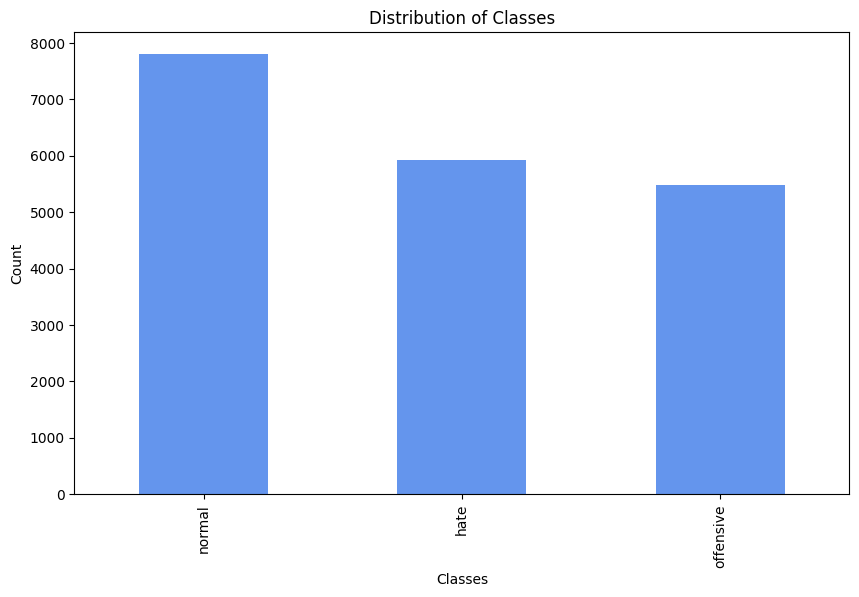

In [ ]:
# normal, hate, offensive로 구성된 각 클래스의 분포 확인
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar', color='cornflowerblue')
plt.title('Distribution of Classes')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

# normal, hate, offensive 샘플 개수 간 차이가 어느 정도 있으나 실험 가설과 real-life situation에 맞춰 좀 더 불균형성을 부여할 필요 있음

In [ ]:
print(df['label'].value_counts())
print(len(df))

label
normal       7800
hate         5926
offensive    5475
Name: count, dtype: int64
19201


In [ ]:
# hate, offensive comment의 비율은 전체에서 약 59%를 차지함 -> 약 42%로 줄이기
normal = df[df['label'] == 'normal']
hate = df[df['label'] == 'hate']
offensive = df[df['label'] == 'offensive']

hate = hate.sample(n=2880)
offensive = offensive.sample(n=2880)

print(len(normal))
print(len(hate))
print(len(offensive))

7800
2880
2880


In [ ]:
df = pd.concat([normal, hate, offensive])
df = df.sample(frac=1).reset_index(drop=True) # concat 후 전체 shuffle, 인덱스 초기화
df.columns = ['comment', 'label']
df

,comment,label
0,my pistol mean business that bitch should have...,normal
1,if they all look like these who am i to block...,normal
2,i am not jewish as it happens but support the ...,hate
3,tweet483 i wanna dye my hair but i already kno...,normal
4,these fucking su calls are just as fucking bad...,offensive
...,...,...
13555,if she d killed a white person she would hav...,normal
13556,the same ‍ account that just told someone to ...,normal
13557,all these niggas is parrots,normal
13558,i wanna get my redneck friends to jump them a...,offensive


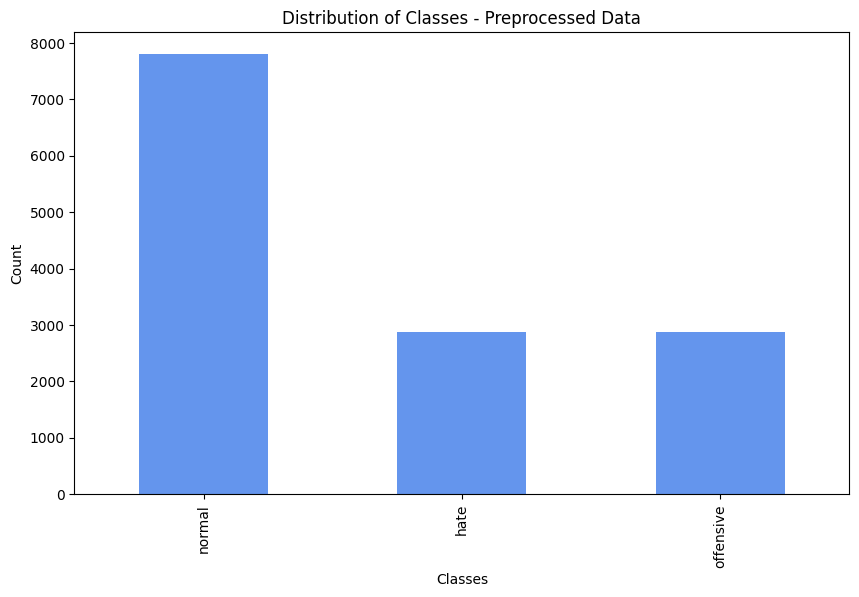

In [ ]:
# 확보된 불균형 데이터셋의 클래스 분포 확인 - normal 70%, offensive 21%, hate 21%
plt.figure(figsize=(10, 6))
df['label'].value_counts().plot(kind='bar', color='cornflowerblue')
plt.title('Distribution of Classes - Preprocessed Data')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

In [ ]:
# 최종 전처리된 데이터 저장
df.to_csv('preprocessed_data.csv')

# 2. Multi-class Text Classification with ML Classifier
- Oversampling 기반의 불균형 데이터 처리 기법을 적용해 혐오표현탐지를 위한 **머신러닝 기반** 텍스트 분류 수행
- 텍스트 Vectorization을 위해 숫자, 문장 부호, stopword, 여분 공백을 제거하고 표제어 추출
- Vectorization을 위해 TF-IDF 적용
- Oversampling 적용 후 클래스 비율 **1:0.6:0.6**
  - 처음에 클래스 비율을 1:1:1로 맞춰 진행하였으나 성능 개선에 미미한 결과를 보여 해당 비율로 수정됨
- **적용된 Oversampling 기법**
  - Random Oversampling (ROS)
  - SMOTE
  - KMeansSMOTE
  - ADASYN
- **사용 모델**
  - `MultinomialNB()`
  - `svm.LinearSVC()`
  - `RandomForestClassifier()`
  - `XGBClassieir()`



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/preprocessed_data.csv')

2-1. Vectorization을 위한 데이터 전처리

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re

nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def remove_numb(text): # 숫자 제거
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

import string
def remove_punctuation(text): # 문장부호 제거
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text): # stopword 제거
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text): # 여분 공백 제거
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def lemmatizing(text): # 표제어 추출 - 단어의 기본형 또는 사전 형태로 식별되는 단일 항목으로 분석할 수 있도록 함
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

In [ ]:
df['comment_clean'] = df['comment'].apply(lambda x: remove_num(x))
df['comment_clean'] = df['comment_clean'].apply(lambda x: remove_punctuation(x))
df['comment_clean'] = df['comment_clean'].apply(lambda x: remove_stopwords(x))
df['comment_clean'] = df['comment_clean'].apply(lambda x: remove_extra_white_spaces(x))
df['comment_clean'] = df['comment_clean'].apply(lambda x: lemmatizing(x))

In [ ]:
# 라벨이 범주형 변수이므로 라벨 인코딩 진행
label_map = {
    'normal': 0,
    'offensive': 1,
    'hate': 2
}

df['label_encoded'] = df['label'].map(label_map)
df = df[['comment', 'label', 'comment_clean', 'label_encoded']]
df

,comment,label,comment_clean,label_encoded
0,her guards should not have any weapons and the...,normal,guard weapon walk chicago ghetto night,0
1,tbh if it wasn ' t for bigag and pornography ...,offensive,tbh bigag pornography would stacking body high...,1
2,shout out to and her hairy brown unwashed cur...,hate,shout hairy brown unwashed curry stench hole h...,2
3,un double standard we did not see tears when m...,normal,un double standard see tear kid west aleppo sl...,0
4,i have been at the rmv for almost an hour but ...,normal,rmv almost hour hear aggressive white boy fail...,0
...,...,...,...,...
13555,yes i still wear muslim symbol,normal,yes still wear muslim symbol,0
13556,syg and castle doctrine laws are ways white...,normal,syg castle doctrine law way white people decla...,0
13557,i want to be the dyke priest,normal,want dyke priest,0
13558,cold lamb mm the bone will be put in the slow ...,normal,cold lamb mm bone put slow cooker overnight be...,0


1-2. Text Vectorization - TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tf_wb= TfidfVectorizer()
X_tf = tf_wb.fit_transform(df['comment_clean'])

# sparse matrix를 array로 변경
X_tf = X_tf.toarray()
X_tf.shape

(13560, 20486)

In [ ]:
# Train, Test Set 분리 (0.8:0.2)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_tf, df['label_encoded'], test_size = 0.2, random_state = 42, stratify=df['label_encoded'])

2-3. Oversampling 없이 분류 수행

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def Classification(model, x_train, y_train, x_test, y_test):

    model.fit(x_train, y_train)
    y_preds = model.predict(x_test)

    print(classification_report(y_test, y_preds))
    print("Confusion matrix: \n", confusion_matrix(y_test, y_preds))

    score = accuracy_score(y_test, y_preds)

    print('\nAccuracy:', score*100)
    print('Training Score: ', model.score(x_train, y_train)*100)

In [ ]:
# 10분~12분 소요

print("1. MultinomialNB")
Classification(MultinomialNB(), x_train, y_train, x_test, y_test)
print("\n2. RandomForest Classifier")
Classification(RandomForestClassifier(), x_train, y_train, x_test, y_test)
print("\n3. XGBoost Classifier")
Classification(XGBClassifier(), x_train, y_train, x_test, y_test)

1. MultinomialNB
              precision    recall  f1-score   support

           0       0.59      0.99      0.74      1560
           1       0.56      0.01      0.02       576
           2       0.78      0.12      0.21       576

    accuracy                           0.60      2712
   macro avg       0.64      0.37      0.32      2712
weighted avg       0.63      0.60      0.47      2712

Confusion matrix: 
 [[1548    3    9]
 [ 561    5   10]
 [ 506    1   69]]

Accuracy: 59.80825958702065
Training Score:  63.891961651917406

2. RandomForest Classifier
              precision    recall  f1-score   support

           0       0.70      0.93      0.80      1560
           1       0.60      0.21      0.31       576
           2       0.78      0.58      0.66       576

    accuracy                           0.70      2712
   macro avg       0.69      0.57      0.59      2712
weighted avg       0.69      0.70      0.67      2712

Confusion matrix: 
 [[1456   59   45]
 [ 406  121   4

In [ ]:
Classification(svm.LinearSVC(), x_train, y_train, x_test, y_test)

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      1560
           1       0.45      0.27      0.34       576
           2       0.68      0.58      0.62       576

    accuracy                           0.68      2712
   macro avg       0.62      0.57      0.58      2712
weighted avg       0.65      0.68      0.66      2712

Confusion matrix: 
 [[1351  135   74]
 [ 338  154   84]
 [ 190   53  333]]

Accuracy: 67.77286135693215
Training Score:  95.07743362831859


1-5. Oversampling 기법 적용 (ROS / SMOTE 계열)
- Random Oversampling (ROS)
- SMOTE
- K-means SMOTE
- ADASYN

In [ ]:
# 1. Random Oversampling (ROS) 적용 - 클래스 비율 1:0.6:0.6
from imblearn.over_sampling import RandomOverSampler

ROS = RandomOverSampler(sampling_strategy = {0:6240, 1:3744, 2:3744})
x_train_ros, y_train_ros = ROS.fit_resample(x_train, y_train)

In [ ]:
# MultinomialNB with ROS
Classification(MultinomialNB(), x_train_ros, y_train_ros, x_test, y_test)

              precision    recall  f1-score   support

           0       0.65      0.95      0.77      1560
           1       0.52      0.11      0.19       576
           2       0.70      0.40      0.51       576

    accuracy                           0.65      2712
   macro avg       0.63      0.49      0.49      2712
weighted avg       0.64      0.65      0.59      2712

Confusion matrix: 
 [[1476   35   49]
 [ 461   66   49]
 [ 319   26  231]]

Accuracy: 65.37610619469027
Training Score:  77.78991841491842


In [ ]:
# LinearSVC with ROS
Classification(svm.LinearSVC(), x_train_ros, y_train_ros, x_test, y_test)

              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1560
           1       0.42      0.33      0.37       576
           2       0.63      0.58      0.60       576

    accuracy                           0.66      2712
   macro avg       0.59      0.57      0.58      2712
weighted avg       0.65      0.66      0.65      2712

Confusion matrix: 
 [[1272  189   99]
 [ 291  189   96]
 [ 169   74  333]]

Accuracy: 66.1504424778761
Training Score:  96.0154428904429


In [ ]:
# RandomForestClassifier with ROS
Classification(RandomForestClassifier(), x_train_ros, y_train_ros, x_test, y_test)

              precision    recall  f1-score   support

           0       0.71      0.93      0.81      1560
           1       0.59      0.23      0.34       576
           2       0.77      0.60      0.67       576

    accuracy                           0.71      2712
   macro avg       0.69      0.59      0.60      2712
weighted avg       0.70      0.71      0.68      2712

Confusion matrix: 
 [[1449   66   45]
 [ 385  135   56]
 [ 206   27  343]]

Accuracy: 71.05457227138643
Training Score:  99.7960372960373


In [ ]:
# XGBoostClassifier with ROS
Classification(XGBClassifier(), x_train_ros, y_train_ros, x_test, y_test)

              precision    recall  f1-score   support

           0       0.74      0.86      0.80      1560
           1       0.49      0.34      0.40       576
           2       0.72      0.63      0.67       576

    accuracy                           0.70      2712
   macro avg       0.65      0.61      0.62      2712
weighted avg       0.68      0.70      0.69      2712

Confusion matrix: 
 [[1342  145   73]
 [ 317  194   65]
 [ 153   60  363]]

Accuracy: 70.02212389380531
Training Score:  81.03146853146853


In [ ]:
# SMOTE 계열 기법 적용을 위한 라이브러리 임포트
from imblearn.over_sampling import SMOTE, KMeansSMOTE, ADASYN, SVMSMOTE

In [ ]:
# 2. SMOTE
SMOTE = SMOTE(sampling_strategy = {0:6240, 1:3744, 2:3744}, k_neighbors = 5)
x_train_smote, y_train_smote = SMOTE.fit_resample(x_train, y_train)

In [ ]:
y_train_smote.value_counts() # 1:0.6:0.6 비율로 오버샘플링 완료

,count
label_encoded,
0,6240
1,3744
2,3744


In [ ]:
# MultinomialNB with SMOTE
Classification(MultinomialNB(), x_train_smote, y_train_smote, x_test, y_test)

              precision    recall  f1-score   support

           0       0.66      0.95      0.78      1560
           1       0.54      0.13      0.21       576
           2       0.71      0.40      0.51       576

    accuracy                           0.66      2712
   macro avg       0.63      0.49      0.50      2712
weighted avg       0.64      0.66      0.60      2712

Confusion matrix: 
 [[1480   37   43]
 [ 449   73   54]
 [ 318   26  232]]

Accuracy: 65.81858407079646
Training Score:  76.93764568764568


In [ ]:
# LinearSVC with SMOTE
Classification(svm.LinearSVC(), x_train_smote, y_train_smote, x_test, y_test)

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1560
           1       0.42      0.35      0.38       576
           2       0.64      0.58      0.61       576

    accuracy                           0.66      2712
   macro avg       0.60      0.58      0.59      2712
weighted avg       0.65      0.66      0.65      2712

Confusion matrix: 
 [[1262  205   93]
 [ 283  201   92]
 [ 171   73  332]]

Accuracy: 66.1873156342183
Training Score:  96.1392773892774


In [ ]:
# RandomfForestClassifier with SMOTE - 3~5분 소요
Classification(RandomForestClassifier(), x_train_smote, y_train_smote, x_test, y_test)

              precision    recall  f1-score   support

           0       0.71      0.93      0.80      1560
           1       0.57      0.23      0.33       576
           2       0.79      0.59      0.67       576

    accuracy                           0.71      2712
   macro avg       0.69      0.58      0.60      2712
weighted avg       0.70      0.71      0.68      2712

Confusion matrix: 
 [[1452   70   38]
 [ 390  133   53]
 [ 206   32  338]]

Accuracy: 70.9070796460177
Training Score:  99.82517482517483


In [ ]:
# XGBoostClassifier with SMOTE - 5분 소요
Classification(XGBClassifier(), x_train_smote, y_train_smote, x_test, y_test)

              precision    recall  f1-score   support

           0       0.73      0.88      0.80      1560
           1       0.51      0.32      0.39       576
           2       0.76      0.62      0.69       576

    accuracy                           0.71      2712
   macro avg       0.67      0.61      0.63      2712
weighted avg       0.69      0.71      0.69      2712

Confusion matrix: 
 [[1380  123   57]
 [ 338  182   56]
 [ 162   54  360]]

Accuracy: 70.87020648967551
Training Score:  82.7287296037296


In [ ]:
# 3. KMeansSMOTE - 2~3분 소요
KMeansSMOTE = KMeansSMOTE(sampling_strategy = {0:6240, 1:3744, 2:3744})
x_train_kmsmote, y_train_kmsmote = KMeansSMOTE.fit_resample(x_train, y_train)

In [ ]:
# MultinomialNB with KMeansSMOTE
Classification(MultinomialNB(), x_train_kmsmote, y_train_kmsmote, x_test, y_test)

              precision    recall  f1-score   support

           0       0.64      0.93      0.76      1560
           1       0.46      0.12      0.19       576
           2       0.70      0.36      0.47       576

    accuracy                           0.64      2712
   macro avg       0.60      0.47      0.47      2712
weighted avg       0.62      0.64      0.58      2712

Confusion matrix: 
 [[1456   62   42]
 [ 459   69   48]
 [ 352   18  206]]

Accuracy: 63.82743362831859
Training Score:  79.78731153033725


In [ ]:
# LinearSVC with KMeansSMOTE
Classification(svm.LinearSVC(), x_train_kmsmote, y_train_kmsmote, x_test, y_test)

              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1560
           1       0.44      0.30      0.35       576
           2       0.68      0.59      0.63       576

    accuracy                           0.68      2712
   macro avg       0.61      0.58      0.59      2712
weighted avg       0.65      0.68      0.66      2712

Confusion matrix: 
 [[1323  162   75]
 [ 320  170   86]
 [ 183   53  340]]

Accuracy: 67.58849557522124
Training Score:  95.95746230606746


In [ ]:
# RandomForestClassifier with KMeansSMOTE
Classification(RandomForestClassifier(), x_train_kmsmote, y_train_kmsmote, x_test, y_test)

              precision    recall  f1-score   support

           0       0.70      0.94      0.80      1560
           1       0.59      0.19      0.28       576
           2       0.77      0.58      0.66       576

    accuracy                           0.70      2712
   macro avg       0.69      0.57      0.58      2712
weighted avg       0.69      0.70      0.66      2712

Confusion matrix: 
 [[1463   53   44]
 [ 413  107   56]
 [ 223   21  332]]

Accuracy: 70.13274336283186
Training Score:  99.83247141088208


In [ ]:
# XGBoostClassifier with KMeansSMOTE
Classification(XGBClassifier(), x_train_kmsmote, y_train_kmsmote, x_test, y_test)

              precision    recall  f1-score   support

           0       0.73      0.89      0.80      1560
           1       0.51      0.30      0.37       576
           2       0.75      0.61      0.67       576

    accuracy                           0.70      2712
   macro avg       0.66      0.60      0.62      2712
weighted avg       0.68      0.70      0.68      2712

Confusion matrix: 
 [[1384  119   57]
 [ 344  170   62]
 [ 175   47  354]]

Accuracy: 70.35398230088495
Training Score:  83.59676596984485


In [ ]:
# 4. ADASYN
ADASYN = ADASYN(sampling_strategy = {0:6240, 1:3744, 2:3744})
x_train_ada, y_train_ada = ADASYN.fit_resample(x_train, y_train)

In [ ]:
# MultinomialNB with ADASYN
Classification(MultinomialNB(), x_train_ada, y_train_ada, x_test, y_test)

              precision    recall  f1-score   support

           0       0.68      0.93      0.78      1560
           1       0.53      0.13      0.21       576
           2       0.66      0.49      0.56       576

    accuracy                           0.67      2712
   macro avg       0.62      0.51      0.52      2712
weighted avg       0.64      0.67      0.61      2712

Confusion matrix: 
 [[1451   44   65]
 [ 422   74   80]
 [ 274   22  280]]

Accuracy: 66.55604719764013
Training Score:  78.7572051173907


In [ ]:
# LinearSVC with ADASYN
Classification(svm.LinearSVC(), x_train_ada, y_train_ada, x_test, y_test)

              precision    recall  f1-score   support

           0       0.74      0.80      0.77      1560
           1       0.41      0.34      0.37       576
           2       0.64      0.59      0.61       576

    accuracy                           0.66      2712
   macro avg       0.60      0.58      0.59      2712
weighted avg       0.65      0.66      0.65      2712

Confusion matrix: 
 [[1251  210   99]
 [ 282  198   96]
 [ 160   74  342]]

Accuracy: 66.03982300884957
Training Score:  96.28848587094053


In [ ]:
# RandomForestClassifier with ADASYN
Classification(RandomForestClassifier(), x_train_ada, y_train_ada, x_test, y_test)

              precision    recall  f1-score   support

           0       0.71      0.93      0.81      1560
           1       0.58      0.23      0.33       576
           2       0.78      0.61      0.68       576

    accuracy                           0.71      2712
   macro avg       0.69      0.59      0.61      2712
weighted avg       0.70      0.71      0.68      2712

Confusion matrix: 
 [[1447   66   47]
 [ 389  133   54]
 [ 195   29  352]]

Accuracy: 71.23893805309734
Training Score:  99.83832419513567


In [ ]:
# XGBoostClassifier with ADASYN
Classification(XGBClassifier(), x_train_ada, y_train_ada, x_test, y_test)

              precision    recall  f1-score   support

           0       0.74      0.88      0.80      1560
           1       0.51      0.32      0.39       576
           2       0.75      0.65      0.69       576

    accuracy                           0.71      2712
   macro avg       0.67      0.61      0.63      2712
weighted avg       0.69      0.71      0.69      2712

Confusion matrix: 
 [[1368  129   63]
 [ 331  185   60]
 [ 157   47  372]]

Accuracy: 70.98082595870207
Training Score:  82.89751159848166


# 3. Multi-class Text Classification with LSTM
- Oversampling 기반의 불균형 처리 기법 중 **ROS**를 적용해 혐오표현탐지를 위한 **LSTM 기반** 텍스트 분류 수행
- 숫자, 문장 부호, stopword, 여분 공백을 제거, 표제어 추출 전처리 과정을 거치고 training, test set 분할 진행 (Stratified)
- training set에 대한 ROS 진행
  - Oversampling 적용 후 클래스 비율 -> 1:1:1
  - 머신러닝 알고리즘과 동일하게 1:0.6:0.6 비율로 오버샘플링 후 학습 시도했으나 여전히 주류 클래스에 과대적합 문제 발생하여 1:1:1로 최종 결정
- 사용 모델: `LSTM`
  - 프레임워크: TensorFlow Keras
  - 워드 임베딩: Word2Vec
  - 손실함수: categorical_crossentropy
  - 옵티마이저: Adam
  - 하이퍼파라미터
    - num_epochs = 15
    - embedding_dim = 25
    - n_layers = 1
    - learning_rate=0.0001, beta_1=0.9, beta_2=0.999
    - dropout = 0.5

In [ ]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf
import numpy as np
import pandas as pd

3-1. 불균형성 확보한 preprocessed_data.csv를 똑같이 전처리 진행

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re

nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def remove_numbers(text): # 숫자 제거
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

import string
def remove_punctuation(text): # 문장부호 제거
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(text): # stopword 제거
    removed = []
    stop_words = list(stopwords.words("english"))
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stop_words:
            removed.append(tokens[i])
    return " ".join(removed)

def remove_extra_white_spaces(text): # 여분 공백 제거
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def lemmatizing(text): # 표제어 추출 - 단어의 기본형 또는 사전 형태로 식별되는 단일 항목으로 분석할 수 있도록 함
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

In [ ]:
df['comment_clean'] = df['comment'].apply(lambda x: remove_numbers(x))
df['comment_clean'] = df['comment_clean'].apply(lambda x: remove_punctuation(x))
df['comment_clean'] = df['comment_clean'].apply(lambda x: remove_stopwords(x))
df['comment_clean'] = df['comment_clean'].apply(lambda x: remove_extra_white_spaces(x))

In [ ]:
# 라벨이 범주형 변수이므로 라벨 인코딩 진행
label_map = {
    'normal': 0,
    'offensive': 1,
    'hate': 2
}

df['label_encoded'] = df['label'].map(label_map)
df = df[['comment', 'label', 'comment_clean', 'label_encoded']]
df

,comment,label,comment_clean,label_encoded
0,her guards should not have any weapons and the...,normal,guards weapons walk chicago ghetto night,0
1,tbh if it wasn ' t for bigag and pornography ...,offensive,tbh bigag pornography would stacking bodies hi...,1
2,shout out to and her hairy brown unwashed cur...,hate,shout hairy brown unwashed curry stench hole h...,2
3,un double standard we did not see tears when m...,normal,un double standard see tears kids west aleppo ...,0
4,i have been at the rmv for almost an hour but ...,normal,rmv almost hour hear aggressive white boy fail...,0
...,...,...,...,...
13555,yes i still wear muslim symbol,normal,yes still wear muslim symbol,0
13556,syg and castle doctrine laws are ways white...,normal,syg castle doctrine laws ways white people dec...,0
13557,i want to be the dyke priest,normal,want dyke priest,0
13558,cold lamb mm the bone will be put in the slow ...,normal,cold lamb mm bone put slow cooker overnight be...,0


3-2. Training, Test set Split (stratified)

In [ ]:
# 분리 전 각 클래스 별 샘플 수 확인
minority_class1 = df[df['label'] == 'offensive']
minority_class2 = df[df['label'] == 'hate']
majority_class = df[df['label'] == 'normal']

print(len(minority_class1))
print(len(minority_class2))
print(len(majority_class))

2880
2880
7800


In [ ]:
# 0.7:0.3 비율로 stratified train-test split 위해 test set 4068개, 그 중 offensive와 hate는 각 855개가 있어야 함
# train-test split 진행

minority_class1 = df[df['label'] == 'offensive'].sample(855)
minority_class2 = df[df['label'] == 'hate'].sample(855)
majority_class = df[df['label'] == 'normal'].sample(2358)

df.drop(minority_class1.index, inplace=True)
df.drop(minority_class2.index, inplace=True)
df.drop(majority_class.index, inplace=True)
df

<ipython-input-9-45fa8026b968>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(minority_class1.index, inplace=True)
<ipython-input-9-45fa8026b968>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(minority_class2.index, inplace=True)
<ipython-input-9-45fa8026b968>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(majority_class.index, inplace=True)


,comment,label,comment_clean,label_encoded
2,shout out to and her hairy brown unwashed cur...,hate,shout hairy brown unwashed curry stench hole h...,2
3,un double standard we did not see tears when m...,normal,un double standard see tears kids west aleppo ...,0
5,seb gorka should be deported for being compl...,normal,seb gorka deported complicit treason spreading...,0
7,i am not a muslin so they probably think i am,normal,muslin probably think,0
10,god will not bless the republican party who ba...,hate,god bless republican party bans christians inc...,2
...,...,...,...,...
13554,i hate you for ignoring me trying to bully yo...,normal,hate ignoring trying bully ig,0
13555,yes i still wear muslim symbol,normal,yes still wear muslim symbol,0
13556,syg and castle doctrine laws are ways white...,normal,syg castle doctrine laws ways white people dec...,0
13558,cold lamb mm the bone will be put in the slow ...,normal,cold lamb mm bone put slow cooker overnight be...,0


In [ ]:
# split 완료
test_set = pd.concat([minority_class1, minority_class2, majority_class])
train_set = df

print(len(test_set), len(train_set))

4068 9492


In [ ]:
# 테스트 셋에 minority class 각 21% 분포 확인
test_set['label'].value_counts()

,count
label,
normal,2358
offensive,855
hate,855


3-3. Training Set Random Oversampling
- 오버샘플링 후 training set 클래스 비율 -> 1:1:1

In [ ]:
minority_class1 = train_set[train_set['label'] == 'offensive']
minority_class2 = train_set[train_set['label'] == 'hate']
majority_class = train_set[train_set['label'] == 'normal']

print(len(minority_class1))
print(len(minority_class2))
print(len(majority_class))

2025
2025
5442


In [ ]:
from sklearn.utils import resample

# minority class 오버샘플링 (1:1:1)
minority_upsampled1 = resample(minority_class1, replace=True, n_samples=3417, random_state=42)
minority_upsampled2 = resample(minority_class2, replace=True, n_samples=3417, random_state=42)

In [ ]:
# minority class와 the majority class 병합
balanced_data = pd.concat([train_set, minority_upsampled1, minority_upsampled2])
balanced_data.reset_index(inplace=True, drop=True)
balanced_data

,comment,label,comment_clean,label_encoded
0,shout out to and her hairy brown unwashed cur...,hate,shout hairy brown unwashed curry stench hole h...,2
1,un double standard we did not see tears when m...,normal,un double standard see tears kids west aleppo ...,0
2,seb gorka should be deported for being compl...,normal,seb gorka deported complicit treason spreading...,0
3,i am not a muslin so they probably think i am,normal,muslin probably think,0
4,god will not bless the republican party who ba...,hate,god bless republican party bans christians inc...,2
...,...,...,...,...
16321,angry bald dyke,hate,angry bald dyke,2
16322,gross muslimes are against same sex attraction...,hate,gross muslimes sex attraction disorder sad yes...,2
16323,aw what wrong nigger you do not like your sheb...,hate,aw wrong nigger like sheboon exposed savage,2
16324,p at least harvey weinstein only raped and ass...,hate,p least harvey weinstein raped assaulted genti...,2


In [ ]:
# 오버샘플링 후 클래스 분포 확인
balanced_data['label'].value_counts()

,count
label,
hate,5442
normal,5442
offensive,5442


In [ ]:
balanced_data = balanced_data.sample(frac=1)  # row 전체 shuffle
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)  # shuffling하고 index reset
balanced_data

,comment,label,comment_clean,label_encoded
0,a gathering of faggots and dykes is a great pl...,hate,gathering faggots dykes great place verify use...,2
1,the muzzie headrag represents nothing more tha...,hate,muzzie headrag represents nothing misogyny opp...,2
2,moslems and their koran are just sandnigger mo...,hate,moslems koran sandnigger mormons book mormons ...,2
3,ya but at least it given rise to alotta order ...,normal,ya least given rise alotta order infrastructur...,0
4,your plan you ain t gonna solve anything stup...,offensive,plan gon na solve anything stupid negro go get...,1
...,...,...,...,...
16321,well here is a good way to get rid of these na...,offensive,well good way get rid nazi coward gop holes well,1
16322,try me u bitch,normal,try bitch,0
16323,color blue and white porcelain,normal,color blue white porcelain,0
16324,daniel did you dress up as arabs and bomb kin...,normal,daniel dress arabs bomb king david hotel distr...,0


In [ ]:
# 오버샘플링된 balanced_data 저장
balanced_data.to_csv('balanced_data.csv')

3-4. Multi-class Classification with Balanced Data

In [ ]:
# 라벨에 대해 원핫인코딩 수행

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(balanced_data[['label']])

training_labels = ohe.transform(balanced_data[['label']])
testing_labels = ohe.transform(test_set[['label']])

len(testing_labels)

4068

In [ ]:
# 토크나이징 수행 전 파라미터 설정
embedding_dim = 25
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_size = 25000

In [ ]:
training_sentences = balanced_data['comment_clean']
testing_sentences = test_set['comment_clean']
training_labels = training_labels
testing_labels = testing_labels

In [ ]:
# 토크나이징 수행 후 sequence로 변환, 패딩 수행
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)

In [ ]:
# 모델에게 feed하기 전 array로 변경
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
testing_labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
# word2vec method로 워드 벡터 형성
words = []

for i in range(len(training_sentences)):
  words.append(training_sentences[i].split())

for i in testing_sentences:
  words.append(i.split())

import gensim
word2vec_model = gensim.models.Word2Vec(vector_size=25, sentences = words, window=5, min_count=1)

In [ ]:
# 임베딩 레이어는 "UNKNOWN" words, padded words (0s)를 위한 벡터를 하나 더 가지므로 현재 vocab_size에 1을 더해줌
# 이 벡터는 0으로 채워짐

vocab_size = len(tokenizer.word_index)+ 1
vocab_size

18751

In [ ]:
# word2vec gensim model로부터 weight matrix를 만들기 위한 함수

def weight_matrix(model,vocab):
    # vocabulary size에 1 더해주기
    vocab_size= len(vocab)+1
    # 0으로 채워진 weight matrix의 차원 정의
    wgt_matrix = np.zeros((vocab_size, embedding_dim))
    # vocab의 단어를 순차적으로 확인, Tokenizer의 정수 매핑을 통해 벡터값 저장
    for word, i in vocab.items():
        wgt_matrix[i]=model[word]
    return wgt_matrix

# word2vec 모델로부터 weight 가져오기 -> 이를 임베딩 레이어에 가중치로 사용함
embedding_vec = weight_matrix(word2vec_model.wv, tokenizer.word_index)

In [ ]:
# word2vec 임베딩 사용해 LSTM 모델 구축하기

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              weights=[embedding_vec], trainable=True), # embedding_vec을 가중치로 삽입
    # LSTM
    tf.keras.layers.LSTM(embedding_dim, dropout=0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999,
                                amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy',tf.keras.metrics.F1Score(average=None)])

In [ ]:
# 모델 학습 진행
num_epochs = 15
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.3437 - f1_score: 0.2210 - loss: 1.0983 - val_accuracy: 0.2252 - val_f1_score: 0.2115 - val_loss: 1.0998
Epoch 2/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.3552 - f1_score: 0.3307 - loss: 1.0955 - val_accuracy: 0.3451 - val_f1_score: 0.3201 - val_loss: 1.1078
Epoch 3/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.3727 - f1_score: 0.3621 - loss: 1.0895 - val_accuracy: 0.4324 - val_f1_score: 0.3586 - val_loss: 1.0897
Epoch 4/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - accuracy: 0.4117 - f1_score: 0.3653 - loss: 1.0717 - val_accuracy: 0.4587 - val_f1_score: 0.3621 - val_loss: 1.0623
Epoch 5/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.4444 - f1_score: 0.3876 - loss: 1.0448 - val_accuracy: 0.5219 - val_f1_score: 0.4298 - val_loss: 0.9962
Epoch 6/15
511/511 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.4467 - f1_score: 0.4189 - loss: 1.0250 - val_accuracy: 0.5489 - val_f1_s

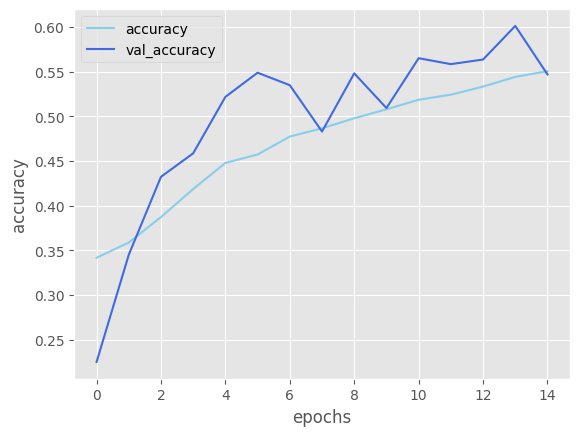

In [ ]:
# training, validation accuracy 시각화

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.plot(history.history['accuracy'],color='skyblue')
plt.plot(history.history['val_accuracy'], color='royalblue')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
# 최종 accuracy, f1score
# 'offensive' f1score - 약 0.65
# 'hate' f1score - 약 0.24

accuracy = history.history['val_accuracy'][-1]
f1score = history.history['val_f1_score'][-1]

print("Accuracy: {}".format(accuracy))
print("F1 Score: {}".format(f1score))

Accuracy: 0.5469518303871155
F1 Score: [0.62120456 0.647874   0.23743312]
